In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pyddm
from pyddm.plot import model_gui_jupyter

# 1.1

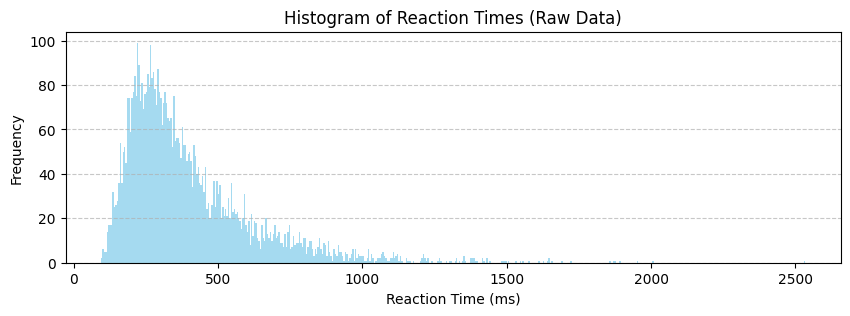

In [281]:
df = pd.read_csv("dataset-7.tsv", sep="\t")
# Convert to ms
df["rt_ms"] = df["rt"] * 1000

# Create bins in milliseconds
bin_size = 5  # 5 ms bins
bins = np.arange(df["rt_ms"].min(), df["rt_ms"].max() + bin_size, bin_size)

# Plot histograms
plt.figure(figsize=(10, 3))
plt.hist(df["rt_ms"], bins=bins, alpha=0.75, color="skyblue")
plt.title("Histogram of Reaction Times (Raw Data)")
plt.xlabel("Reaction Time (ms)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# 1.2

Average Reaction Time (ms): 390.47407496315185
Median Reaction Time (ms): 333.171549970383


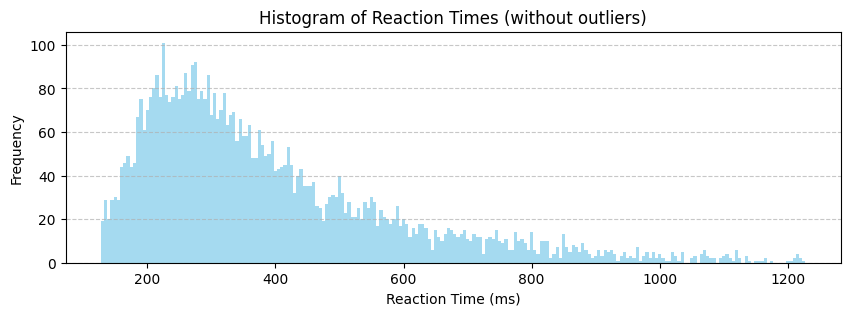

In [282]:
q_low = df["rt_ms"].quantile(0.01)
q_hi  = df["rt_ms"].quantile(0.99)

data_without_outlier = df[(df["rt_ms"] <= q_hi) & (df["rt_ms"] > q_low)]

# Calculate the average and median
average_rt = data_without_outlier["rt_ms"].mean()
median_rt = data_without_outlier["rt_ms"].median()

print(f"Average Reaction Time (ms): {average_rt}")
print(f"Median Reaction Time (ms): {median_rt}")

# Create bins for data without outlier
bins = np.arange(data_without_outlier["rt_ms"].min(), data_without_outlier["rt_ms"].max() + bin_size, bin_size)

# Plot histograms
plt.figure(figsize=(10, 3))
plt.hist(data_without_outlier["rt_ms"], bins=bins, alpha=0.75, color="skyblue")
plt.title("Histogram of Reaction Times (without outliers)")
plt.xlabel("Reaction Time (ms)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# 1.3

In [283]:
def plot_histogram(rt1, rt2, label1, label2, title):
    # Plot histograms
    plt.figure(figsize=(5, 3))

    # Plot Correct RTs
    plt.hist(rt1, bins=bins, alpha=0.75, color="skyblue", label=label1)
    plt.hist(rt2, bins=bins, alpha=0.75, color="lightcoral", label=label2)
    plt.title(title)
    plt.xlabel("Reaction Time (ms)")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.25)

    plt.show()

def density_plot(df,rt1, rt2, label1, label2, title):
    density_1_rts = scipy.stats.gaussian_kde(rt1)
    density_2_rts = scipy.stats.gaussian_kde(rt2)

    xs = np.linspace(df["rt_ms"].min(),df["rt_ms"].max(),200)

    density_1_rts.covariance_factor = lambda : .25
    density_2_rts.covariance_factor = lambda : .25

    density_1_rts._compute_covariance()
    density_2_rts._compute_covariance()

    plt.figure(figsize=(5, 3))

    plt.plot(xs,density_1_rts(xs), color = "skyblue", label=label1)
    plt.plot(xs,density_2_rts(xs), color = "lightcoral", label=label2)
    plt.title(title)
    plt.xlabel("Reaction Time (ms)")
    plt.ylabel("Density")
    plt.legend(loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

C:\Users\grjoo\AppData\Local\Temp\ipykernel_30364\4108769967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_outlier["correct"] = (data_without_outlier["S"] == data_without_outlier["R"]).astype(int)


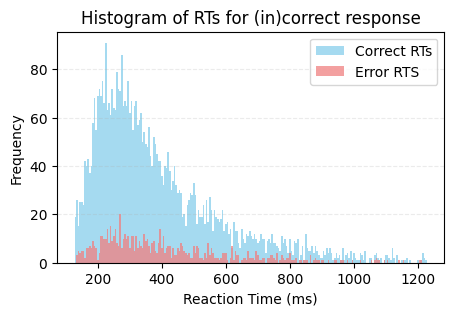

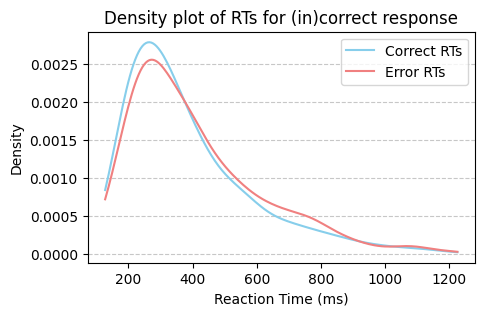

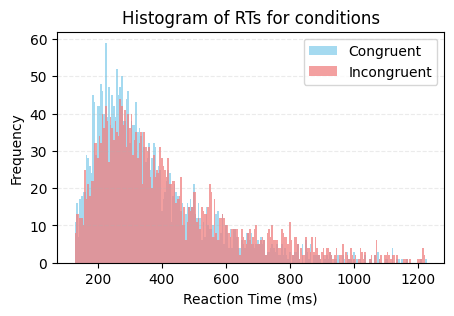

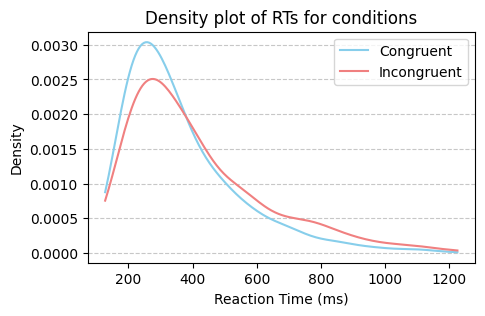

In [284]:
# Add a "correct" column: whether S == R (1 if correct, 0 if not)
data_without_outlier["correct"] = (data_without_outlier["S"] == data_without_outlier["R"]).astype(int)

correct_rts = data_without_outlier[data_without_outlier["correct"] == 1]["rt_ms"]
error_rts = data_without_outlier[data_without_outlier["correct"] == 0]["rt_ms"]

plot_histogram(correct_rts, error_rts, "Correct RTs", "Error RTS", "Histogram of RTs for (in)correct response")

density_plot(data_without_outlier, correct_rts, error_rts, "Correct RTs", "Error RTs", "Density plot of RTs for (in)correct response")

congruent_rts = data_without_outlier[data_without_outlier["flankers"] == "congruent"]["rt_ms"]
incongruent_rts = data_without_outlier[data_without_outlier["flankers"] == "incongruent"]["rt_ms"]

plot_histogram(congruent_rts, incongruent_rts, "Congruent", "Incongruent", "Histogram of RTs for conditions")

density_plot(data_without_outlier, congruent_rts, incongruent_rts, "Congruent", "Incongruent", "Density plot of RTs for conditions")

# Paired T-test of correctness per condition

# 2.1

In [285]:
def t_test_paired(a, b, plot_title, label_a, label_b, y_label):
    # Perform a paired t-test
    t_stat, p_value = scipy.stats.ttest_rel(a, b)

    print(f"Paired t-test results:\n  t-statistic = {t_stat:.2f}\n  p-value = {p_value:.7f}")

    # If plot_title is empty or false, dont plot
    if plot_title:
        a.reset_index(drop=True, inplace=True)
        b.reset_index(drop=True, inplace=True)

        # Plot the data
        plt.figure(figsize=(6, 6))

        # Boxplot for the two conditions
        bplot = plt.boxplot([a, b], labels=[label_a, label_b], patch_artist=True)
        for patch, color in zip(bplot["boxes"], ["skyblue","lightcoral"]):
            patch.set_facecolor(color)
        plt.title(plot_title)
        plt.ylabel(y_label)
        plt.grid(axis="y", linestyle="--", alpha=0.25)
        plt.tight_layout()
        plt.show()


# 2.2

Paired t-test results:
  t-statistic = -5.28
  p-value = 0.0002621


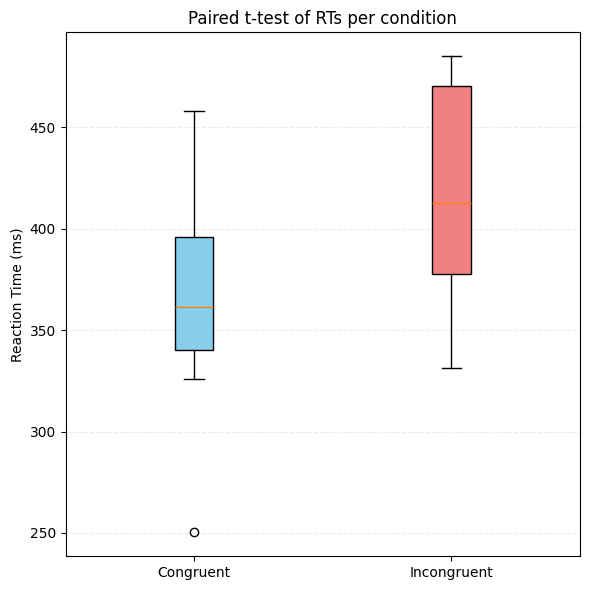

In [286]:
# Aggregate: compute mean "reaction time" per subject and flanker condition
agg_rt = data_without_outlier.groupby(["subjects", "flankers"])["rt_ms"].mean().reset_index()

# Select the rt based on the condition
rt_responses_congruent = agg_rt[agg_rt["flankers"] == "congruent"]["rt_ms"]
rt_responses_incongruent = agg_rt[agg_rt["flankers"] == "incongruent"]["rt_ms"]

t_test_paired(rt_responses_congruent, rt_responses_incongruent, "Paired t-test of RTs per condition","Congruent","Incongruent","Reaction Time (ms)")

Paired t-test results:
  t-statistic = 2.59
  p-value = 0.0250483


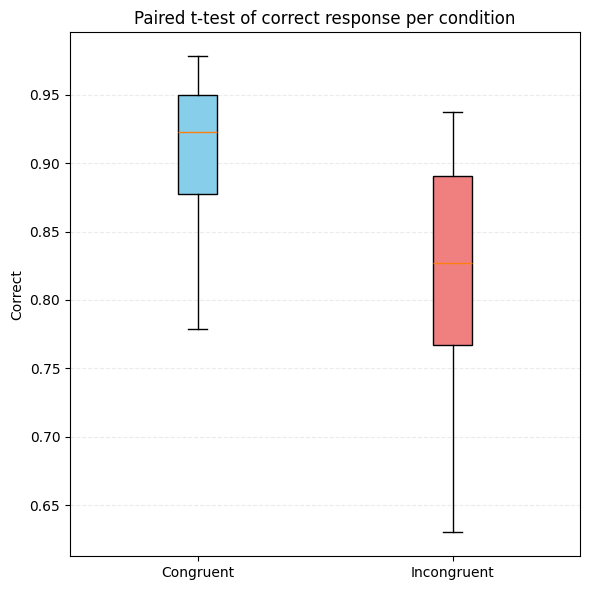

In [287]:
# Aggregate: compute mean "correct" per subject and flanker condition
agg_c = data_without_outlier.groupby(["subjects", "flankers"])["correct"].mean().reset_index()

# Select the correct proportion based on the condition
correct_responses_congruent = agg_c[agg_c["flankers"] == "congruent"]["correct"]
correct_responses_incongruent = agg_c[agg_c["flankers"] == "incongruent"]["correct"]

t_test_paired(correct_responses_congruent, correct_responses_incongruent, "Paired t-test of correct response per condition","Congruent","Incongruent","Correct")

# 3.1

In [288]:
rows = []  # Create a list to store rows temporarily
# Loop over every subject in the data
for subject in data_without_outlier["subjects"].unique():
    # For both conditions fit a model
    for condition in data_without_outlier["flankers"].unique():
        # Get the data for the subject and the condition
        df_sub = data_without_outlier[(data_without_outlier["subjects"] == subject) & (data_without_outlier["flankers"] == condition)]
        
        # Make a pyddm sample from the data
        sample = pyddm.Sample.from_pandas_dataframe(df_sub, rt_column_name="rt", choice_column_name="correct")
        
        # Define and fit the model
        model = pyddm.gddm(
            drift="driftrate", 
            noise="std",
            bound="B", 
            starting_position="x0", 
            nondecision="ndtime",
            parameters={
                "driftrate": (-3, 3), 
                "std":(.1,1),
                "B": (.3, 2), 
                "x0": (-.5, .5), 
                "ndtime": (0, .5)
            }
        )

        model.fit(sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)
        
        # Extract parameters
        driftrate, noise, bound, starting_point, Ter = model.get_model_parameters()
        
        # Append row as a dictionary to the rows list
        rows.append({
            "subject": subject,
            "condition": condition,
            "driftrate": driftrate,
            "noise": noise,
            "bound": bound,
            "starting_point": starting_point,
            "Ter": Ter
        })

# Merge all rows into the Parameters DataFrame
Parameters = pd.DataFrame(rows)

Info: Params [ 0.96654646  0.98695514  0.58810356 -0.04863364  0.15201353] gave 77.16661083455799
Info: Params [0.97366526 0.9009362  0.528992   0.00413823 0.15036224] gave 50.79948421717958
Info: Params [ 1.35870385  0.94957758  0.56050806 -0.00348796  0.09361679] gave 13.289814134858666
Info: Params [2.03903276 0.93201346 0.56432556 0.07584678 0.09330899] gave -84.41235806269565
Info: Params [ 0.93850519  0.52408671  0.31558663 -0.03904078  0.09857833] gave -15.939697978768457
Info: Params [1.16448228 0.93279365 0.54990013 0.0578078  0.10360042] gave 18.610659328152735
Info: Params [1.18731176 0.81466707 0.37283881 0.08554191 0.16986078] gave -83.2368638462313
Info: Params [ 1.8922367   0.81497246  0.38191337 -0.02227063  0.16169694] gave -137.28259501289597
Info: Params [ 0.52599621  0.84620779  0.49355252 -0.07293726  0.16457498] gave 89.1281124480021
Info: Params [ 2.36760504  0.75387123  0.48236919 -0.02158642  0.17038355] gave -169.31187425930455
Info: Params [0.86376497 0.79787

# 3.2

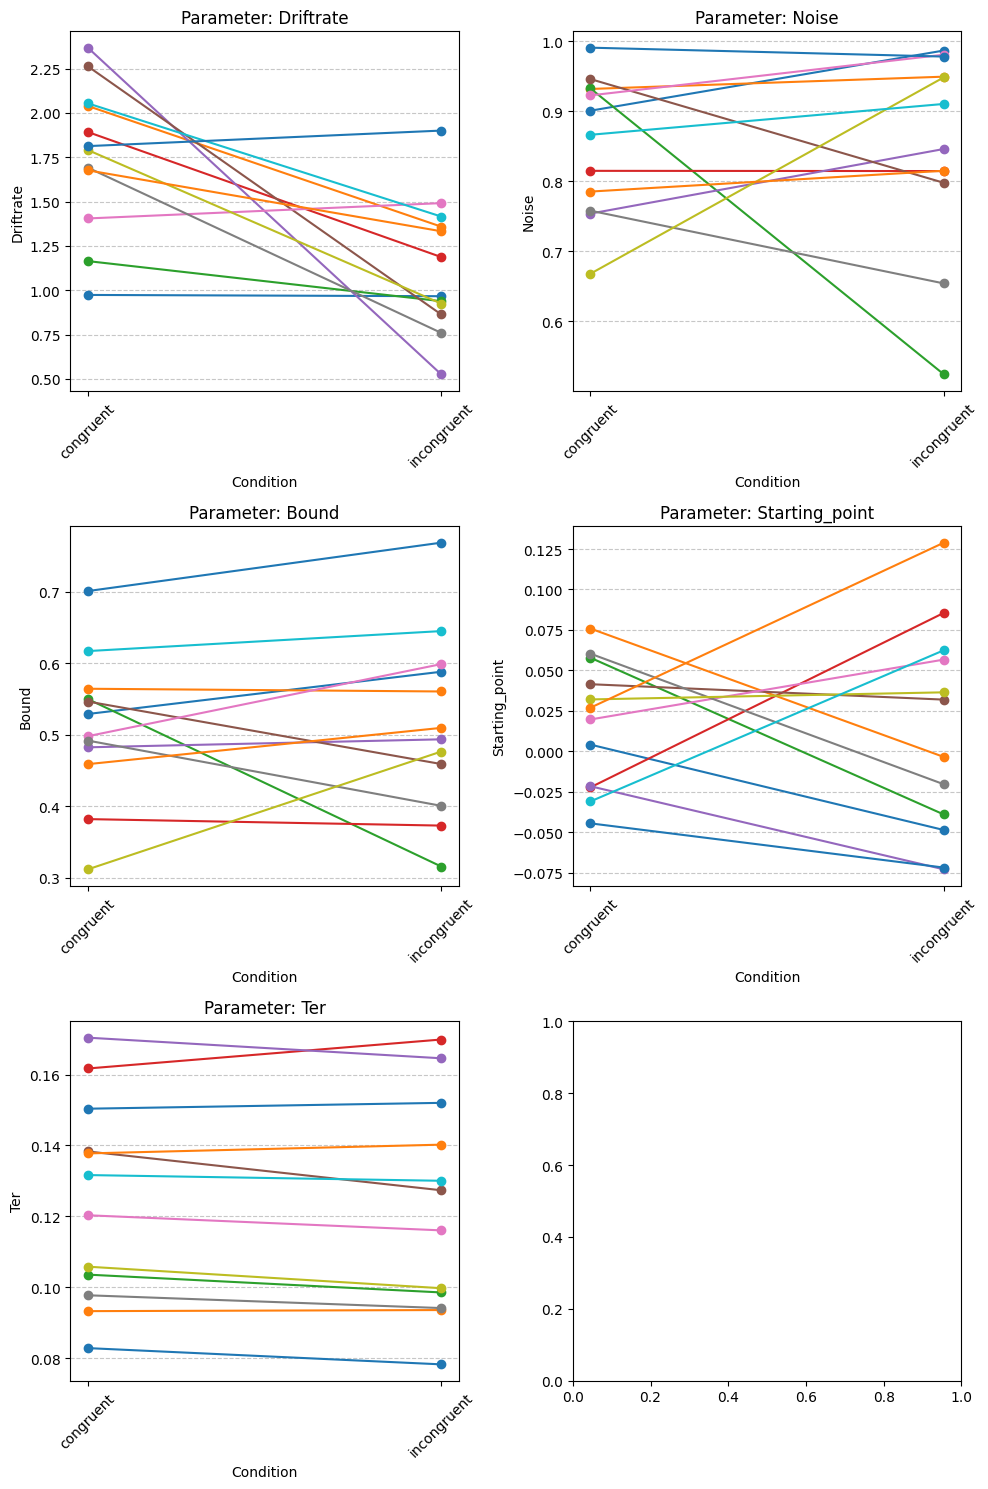

In [289]:
# List of parameters to plot
parameters = ["driftrate", "noise", "bound", "starting_point", "Ter"]

# Initialize a figure with 5 subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharey=False)

axes = axes.flatten()

# Loop through each parameter and create a subplot
for i, param in enumerate(parameters):
    ax = axes[i]
    for subject in Parameters["subject"].unique():
        # Filter data for each subject
        subject_data = Parameters[Parameters["subject"] == subject]
        ax.plot(subject_data["condition"].iloc[::-1], subject_data[param].iloc[::-1], marker='o', linestyle='-', label=f"Subject {subject}")
    
    # Subplot formatting
    ax.set_title(f"Parameter: {param.capitalize()}")
    ax.set_xlabel("Condition")
    ax.set_ylabel(f"{param.capitalize()}")
    ax.set_xticks(subject_data["condition"].unique())
    ax.set_xticklabels(subject_data["condition"].unique(), rotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show
plt.tight_layout()
plt.show()


# 3.3

Paired t-test results:
  t-statistic = 3.63
  p-value = 0.0039541


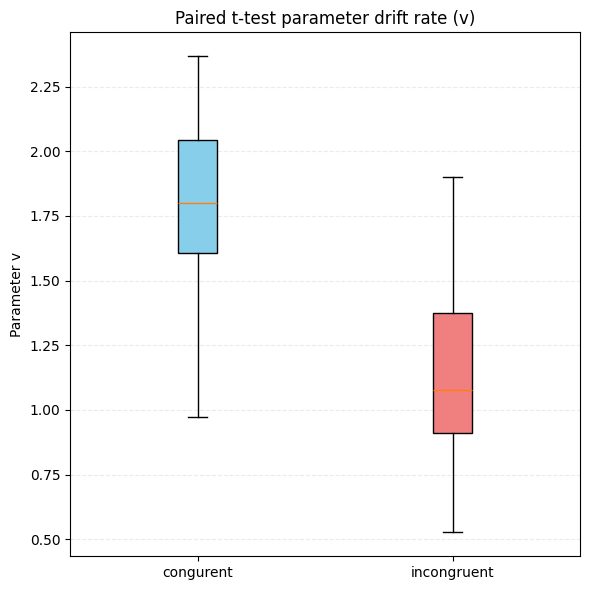

Paired t-test results:
  t-statistic = 0.11
  p-value = 0.9112251


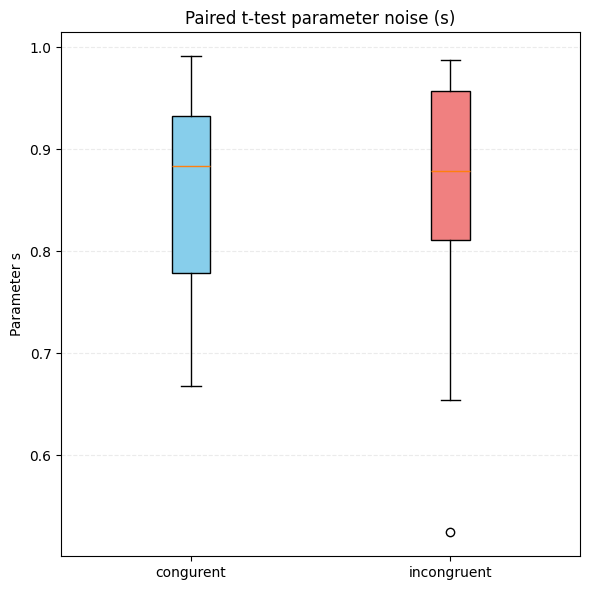

Paired t-test results:
  t-statistic = -0.16
  p-value = 0.8787236


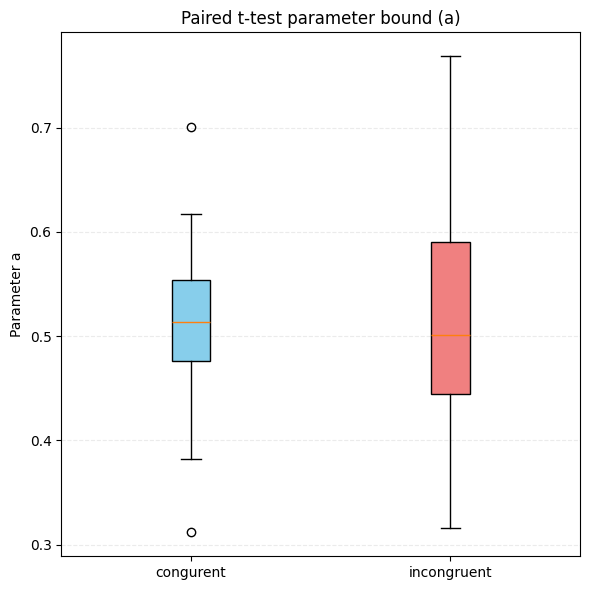

Paired t-test results:
  t-statistic = 0.21
  p-value = 0.8393115


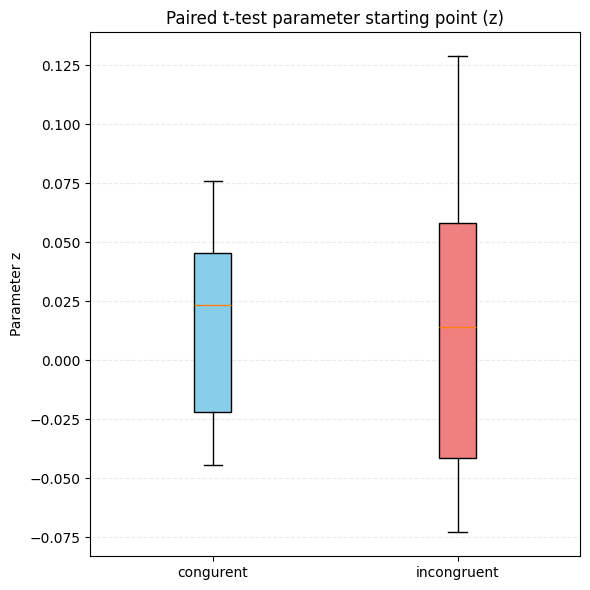

Paired t-test results:
  t-statistic = 1.69
  p-value = 0.1183061


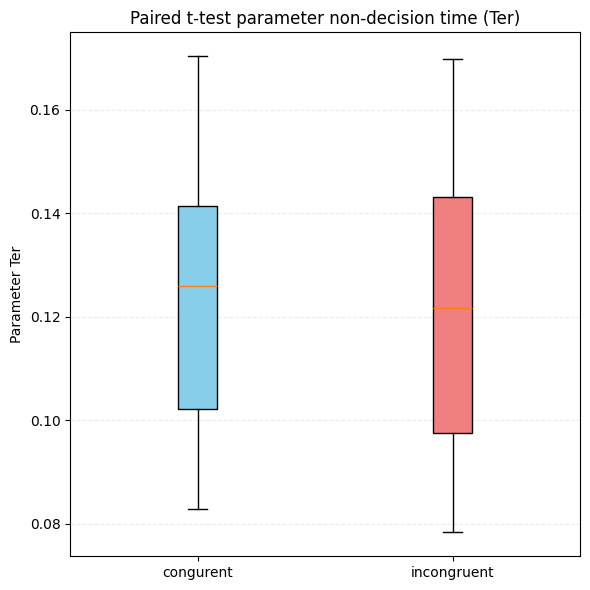

In [290]:
# For every parameter do a paired t-test
for parameter in parameters:
    # Split the data between the two condtions
    parameter_congruent = Parameters[Parameters["condition"] == "congruent"][parameter]
    parameter_incongruent = Parameters[Parameters["condition"] == "incongruent"][parameter]
    match parameter:
        case "driftrate":
            t_test_paired(parameter_congruent, parameter_incongruent, "Paired t-test parameter drift rate (v)", "congurent", "incongruent", "Parameter v")
        case "noise":
            t_test_paired(parameter_congruent, parameter_incongruent, "Paired t-test parameter noise (s)", "congurent", "incongruent", "Parameter s")
        case "bound":
            t_test_paired(parameter_congruent, parameter_incongruent, "Paired t-test parameter bound (a)", "congurent", "incongruent", "Parameter a")
        case "starting_point":
            t_test_paired(parameter_congruent, parameter_incongruent, "Paired t-test parameter starting point (z)", "congurent", "incongruent", "Parameter z")
        case "Ter":
            t_test_paired(parameter_congruent, parameter_incongruent, "Paired t-test parameter non-decision time (Ter)", "congurent", "incongruent", "Parameter Ter")
        case _:
            print("Column does not exist") 